# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from abc import ABC
import random
from typing import Dict, Callable, Tuple
import cv2

import matplotlib.pyplot as plt
import numpy
from sklearn.datasets import make_blobs, make_moons
from sklearn.neighbors import KDTree

In [2]:
SEED = 7

numpy.random.seed(SEED)
random.seed(SEED)

In [3]:
def visualize_clusters(X, labels):
    unique_labels = numpy.unique(labels)
    unique_colors = numpy.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

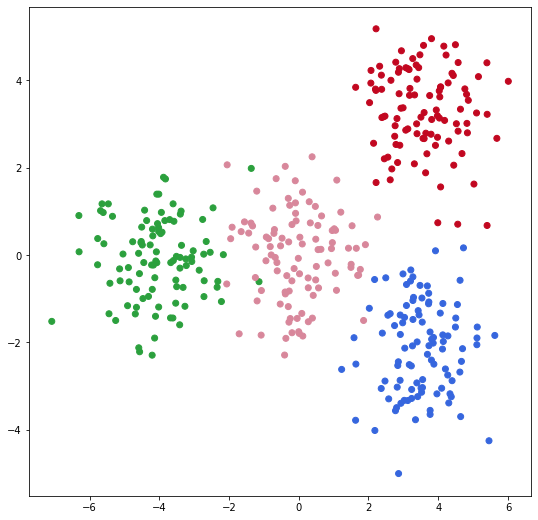

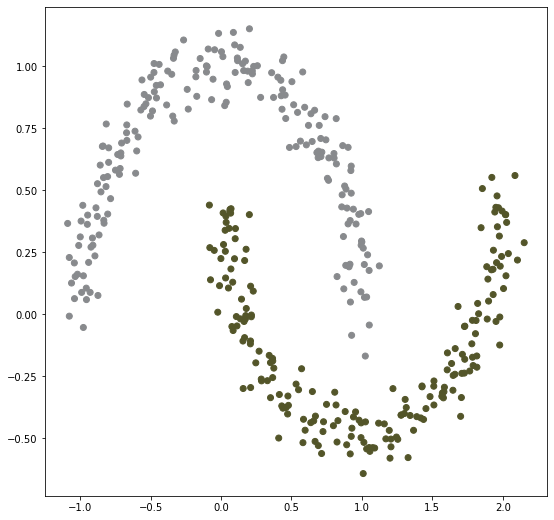

In [4]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clusters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clusters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудьте реинициализировать пустые кластеры!__

In [5]:
def get_euclidean_distances(
        from_points: numpy.ndarray, to_points: numpy.ndarray
) -> numpy.ndarray:
    return numpy.linalg.norm(from_points[:, None, :] - to_points, axis=2)

def get_manhattan_distances(
        from_points: numpy.ndarray, to_points: numpy.ndarray
) -> numpy.ndarray:
    return numpy.abs(from_points[:, None, :] - to_points).sum(axis=2)

def get_chebyshev_distance(
        from_points: numpy.ndarray, to_points: numpy.ndarray
) -> numpy.ndarray:
    return numpy.abs(from_points[:, None, :] - to_points).max(axis=2)

In [6]:
class AbstractCentroidBuilder(ABC):
    name: str = None

    def _generate_centroids(self, x: numpy.ndarray, k: int) -> numpy.ndarray:
        raise NotImplementedError()

    @staticmethod
    def _validate_centroids( x: numpy.ndarray, centroids: numpy.ndarray) -> bool:
        p_dists = get_euclidean_distances(x, centroids)
        closest_centroid = numpy.argmin(p_dists, axis=1)
        return numpy.unique(closest_centroid).shape[0] == centroids.shape[0]

    def build(self, x: numpy.ndarray, k: int) -> numpy.ndarray:
        centroids = self._generate_centroids(x, k)
        while not self._validate_centroids(x, centroids):
            centroids = self._generate_centroids(x, k)
        return centroids

class RandomCentroidBuilder(AbstractCentroidBuilder):
    name: str = "random"
    def _generate_centroids(self, x: numpy.ndarray, k: int) -> numpy.ndarray:
        min_per_feature = numpy.min(x, axis=0)
        max_per_feature = numpy.max(x, axis=0)
        feature_variance = max_per_feature - min_per_feature
        return feature_variance * numpy.random.randn(k, x.shape[1]) + min_per_feature

class SampleCentroidBuilder(AbstractCentroidBuilder):
    name: str = "sample"
    def _generate_centroids(self, x: numpy.ndarray, k: int) -> numpy.ndarray:
        return x[numpy.random.choice(x.shape[0], k, replace=False)]

class KMeansPlusCentroidBuilder(AbstractCentroidBuilder):
    name: str = "kmeans++"
    def _generate_centroids(self, x: numpy.ndarray, k: int) -> numpy.ndarray:
        centroid_ids = [numpy.random.choice(x.shape[0])]
        for i in range(1, k):
            p_dists = get_euclidean_distances(x, x[centroid_ids])
            dist_to_farthest_cluster = numpy.square(numpy.min(p_dists, axis=1))
            dist_to_farthest_cluster[centroid_ids] = 0
            probs = dist_to_farthest_cluster / dist_to_farthest_cluster.sum()
            centroid_ids.append(numpy.random.choice(x.shape[0], p=probs))
        return x[centroid_ids]

In [7]:
class KMeans:
    _known_centroid_builders: Dict[str, AbstractCentroidBuilder.__class__] = {
        RandomCentroidBuilder.name: RandomCentroidBuilder,
        SampleCentroidBuilder.name: SampleCentroidBuilder,
        KMeansPlusCentroidBuilder.name: KMeansPlusCentroidBuilder
    }

    _centroids: numpy.ndarray = None
    _x: numpy.ndarray = None
    _clusters_ids: numpy.ndarray = None

    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300):
        """
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для K-means.
        """
        self._n_clusters = n_clusters
        self._max_iter = max_iter
        if init not in self._known_centroid_builders:
            raise ValueError(f"Unknown way to initialize clusters centroids: {init}")
        self._centroid_builder = self._known_centroid_builders[init]()

    def fit(self, x: numpy.array, y: numpy.array = None):
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        x : numpy.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """
        self._x = x.copy()
        self._centroids = self._centroid_builder.build(x, self._n_clusters)
        p_dists = get_euclidean_distances(self._x, self._centroids)
        self._clusters_ids = numpy.argmin(p_dists, axis=1)
        for _ in range(self._max_iter):
            for cluster_id in range(self._n_clusters):
                point_mask = self._clusters_ids == cluster_id
                self._centroids[cluster_id] = self._x[point_mask].mean(axis=0)
            p_dists = get_euclidean_distances(self._x, self._centroids)
            new_clusters_ids = numpy.argmin(p_dists, axis=1)
            if (new_clusters_ids == self._clusters_ids).sum() == self._x.shape[0]:
                break
            self._clusters_ids = new_clusters_ids

    def predict(self, x: numpy.array) -> numpy.array:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        x : numpy.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : numpy.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        if self._centroids is None:
            raise RuntimeError("Fit estimator before predicting")
        return numpy.argmin(get_euclidean_distances(x, self._centroids), axis=1)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

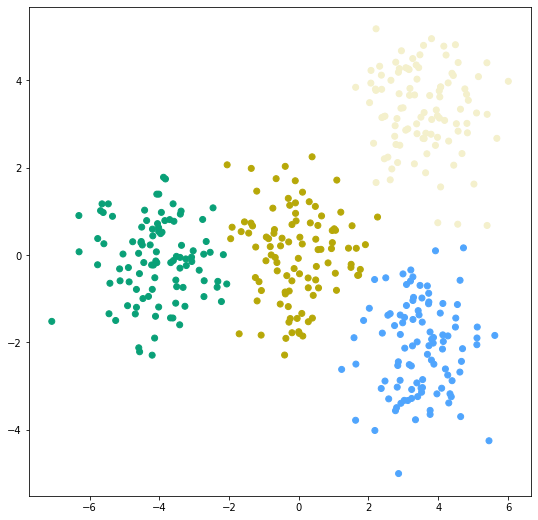

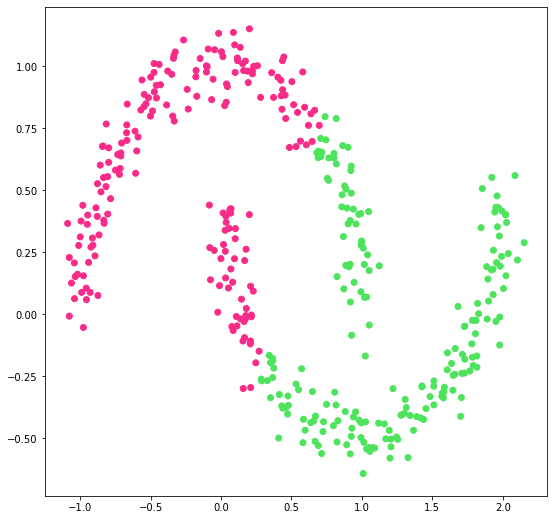

In [8]:
kmeans = KMeans(n_clusters=4, init="kmeans++")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clusters(X_1, labels)

kmeans = KMeans(n_clusters=2, init="kmeans++")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clusters(X_2, labels)

### Задание 2 (2 балла)
В отличие от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [9]:
class DBScan:
    _known_metric_functions: Dict[str, Callable] = {
        "euclidean": get_euclidean_distances,
        "manhattan": get_manhattan_distances,
        "chebyshev": get_chebyshev_distance
    }
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        """
        
        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть 
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean 
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self._eps = eps
        self._min_samples = min_samples
        if metric not in self._known_metric_functions:
            raise ValueError(f"Unknown metric function: {metric}")
        self._metric = metric
        self._get_distance = self._known_metric_functions[metric]
        self._kdtree_leaf_size = leaf_size

    def fit_predict(self, x: numpy.array, y = None) -> numpy.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        x : numpy.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : numpy.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        kd_tree = KDTree(x, self._kdtree_leaf_size, self._metric)
        eps_neighborhood = kd_tree.query_radius(x, self._eps)
        n_neighbours = [n.shape[0] for n in eps_neighborhood]
        cluster_ids = numpy.full(x.shape[0], -1, dtype=numpy.short)
        current_cluster = 0
        for center in range(x.shape[0]):
            if n_neighbours[center] < self._min_samples or cluster_ids[center] != -1:
                continue
            self._update_cluster(center, cluster_ids, eps_neighborhood, current_cluster)
            current_cluster += 1
        cluster_ids[cluster_ids == -1] = current_cluster
        return cluster_ids

    def _update_cluster(
            self,
            center: int,
            cluster_ids: numpy.ndarray,
            eps_neighborhood: numpy.ndarray,
            current_cluster: int
    ):
        bfs_mask = numpy.zeros(cluster_ids.shape[0], dtype=numpy.bool)
        used = numpy.zeros_like(bfs_mask)
        next_bfs_mask = numpy.zeros_like(bfs_mask)
        bfs_mask[center] = True
        while bfs_mask.sum() > 0:
            cluster_ids[bfs_mask] = current_cluster
            used[bfs_mask] = True
            next_bfs_mask[:] = False
            for next_center in numpy.argwhere(bfs_mask)[:, 0]:
                if eps_neighborhood[next_center].shape[0] >= self._min_samples:
                    next_bfs_mask[eps_neighborhood[next_center]] = True
            bfs_mask = numpy.logical_and(next_bfs_mask, ~used)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

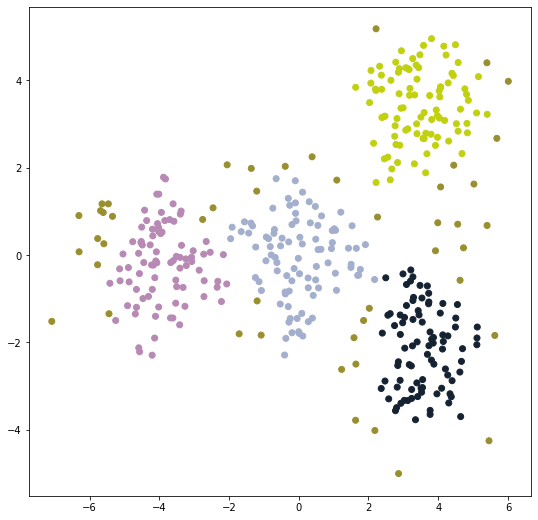

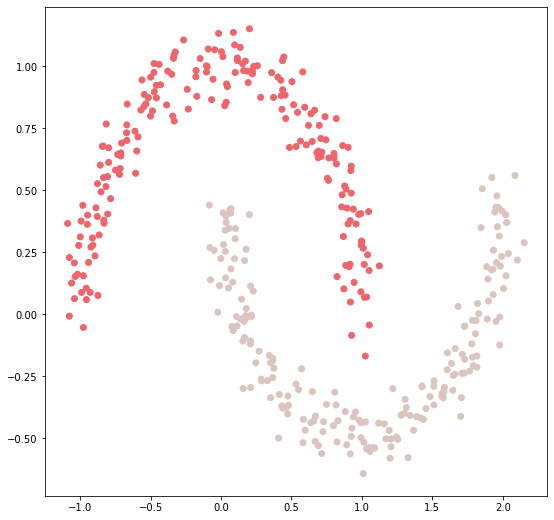

In [10]:
dbscan = DBScan(eps=0.5, min_samples=6, metric="chebyshev")
labels = dbscan.fit_predict(X_1)
visualize_clusters(X_1, labels)

dbscan = DBScan(eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clusters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [11]:
def get_average_linkage_params(u_size: int, v_size: int) -> Tuple[float, float, float, float]:
    new_size = u_size + v_size
    return u_size / new_size, v_size / new_size, 0, 0

def get_single_linkage_params(u_size: int, v_size: int) -> Tuple[float, float, float, float]:
    return 0.5, 0.5, 0, -0.5

def get_complete_linkage_params(u_size: int, v_size: int) -> Tuple[float, float, float, float]:
    return 0.5, 0.5, 0, 0.5

In [12]:
class AgglomerativeClustering:

    _known_linkages = {
        "average": get_average_linkage_params,
        "single": get_single_linkage_params,
        "complete": get_complete_linkage_params
    }
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """
        
        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры 
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        self._n_clusters = n_clusters
        if linkage not in self._known_linkages:
            raise ValueError(f"Unknown linkage: {linkage}")
        self._linkage = self._known_linkages[linkage]

    def fit_predict(self, x: numpy.array, y = None) -> numpy.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        x : numpy.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : numpy.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).
        """
        n_clusters = x.shape[0]
        cluster_ids = numpy.arange(n_clusters)
        cluster_dists = get_euclidean_distances(x, x)
        for _ in range(x.shape[0] - self._n_clusters):
            triu_idx = numpy.triu_indices(n_clusters, k=1)
            min_dist = numpy.min(cluster_dists[triu_idx])
            u, v = numpy.argwhere(cluster_dists == min_dist)[0]
            if u > v:
                u, v = v, u
            u_size = (cluster_ids == u).sum()
            v_size = (cluster_ids == v).sum()
            # Lans-Williams params
            alpha_u, alpha_v, beta, gamma = self._linkage(u_size, v_size)
            cluster_dists[u] =\
                alpha_u * cluster_dists[u] +\
                alpha_v * cluster_dists[v] +\
                beta * cluster_dists[u, v] +\
                gamma * numpy.abs(cluster_dists[u] - cluster_dists[v])
            cluster_dists[:, u] = cluster_dists[u, :]
            cluster_dists[v] = cluster_dists[n_clusters - 1]
            cluster_dists[:, v] = cluster_dists[v, :]
            cluster_dists[u, u] = cluster_dists[v, v] = 0.
            cluster_ids[cluster_ids == v] = u
            cluster_ids[cluster_ids == (n_clusters - 1)] = v
            n_clusters -= 1
            cluster_dists = cluster_dists[:n_clusters, :n_clusters]
        return cluster_ids

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

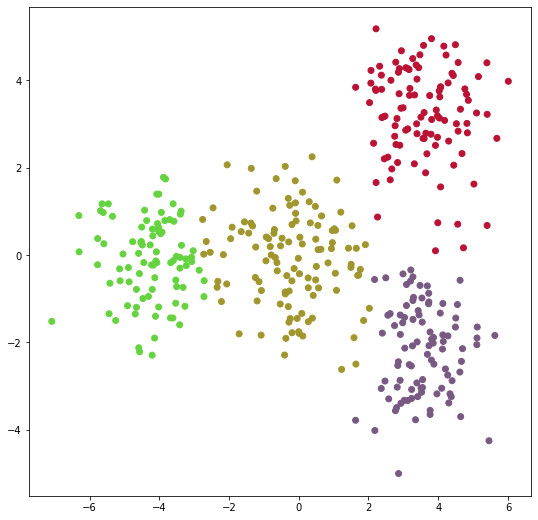

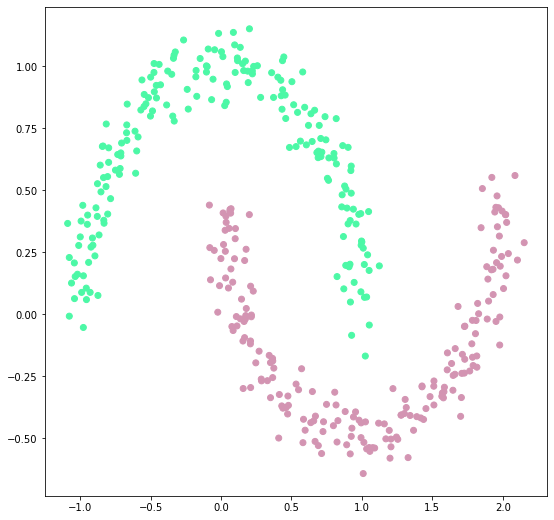

In [13]:
agg_clustering = AgglomerativeClustering(n_clusters=4, linkage="complete")
labels = agg_clustering.fit_predict(X_1)
visualize_clusters(X_1, labels)

agg_clustering = AgglomerativeClustering(n_clusters=2, linkage="single")
labels = agg_clustering.fit_predict(X_2)
visualize_clusters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [14]:
def read_image(path: str) -> numpy.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : numpy.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    image = cv2.imread(path)
    image[:, :, [0, 1, 2]] = image[:, :, [2, 1, 0]]
    return image / 255


def show_image(image: numpy.array):
    """
    Выводит изображение

    Parameters
    ----------
    image : numpy.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=numpy.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: numpy.array, path: str):
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : numpy.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    image = (image * 255).astype(numpy.uint8)
    cv2.imwrite(path, image)

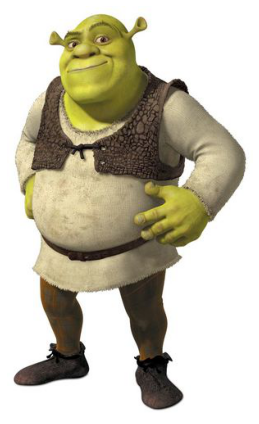

In [15]:
show_image(read_image("./image.jpg"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [16]:
def clusterize_image(image: numpy.ndarray, n_clusters: int):
    model = KMeans(n_clusters, init='kmeans++')
    model.fit(image.reshape(-1, 3))
    cluster_colors = model._centroids
    clusters = model._clusters_ids
    recolored = cluster_colors[clusters].reshape(image.shape)
    
    clusters_statistics(image.reshape(-1, 3), cluster_colors, clusters) # Very slow (:
    return recolored

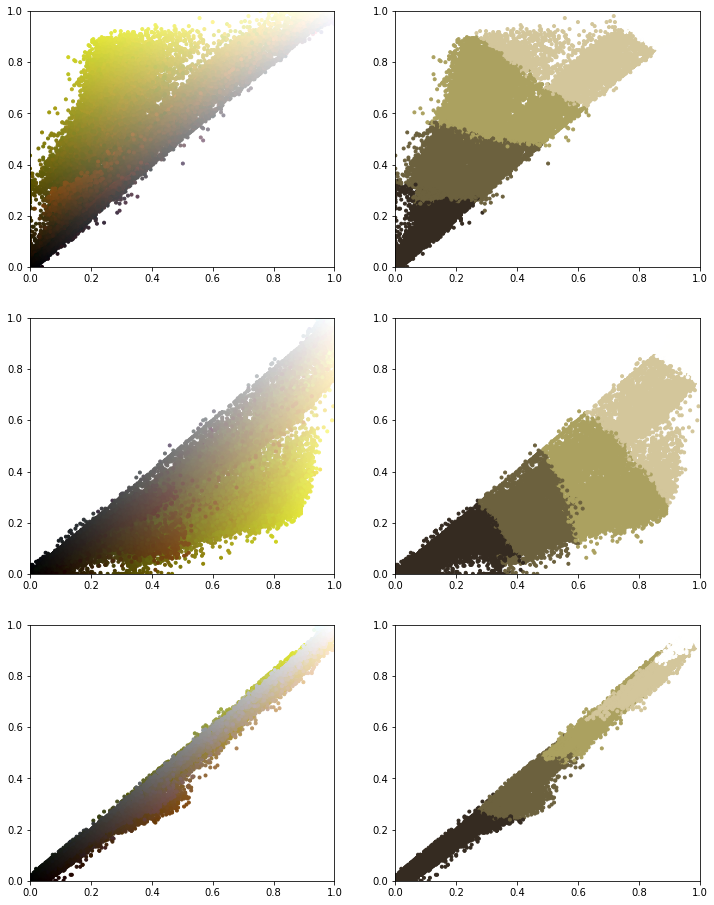

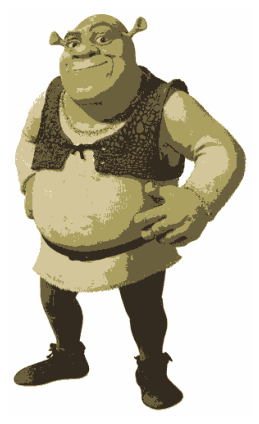

In [17]:
image = read_image("./image.jpg")
result = clusterize_image(image, 5)
show_image(result)
save_image(result, "result.jpg")